# COP MDU Documento Técnico v1.0

In [1]:
import document as doc

Para rodar queries é necessário ter mysql instalado e ter o pacote python pymysql. Para o mysql pode rodar o comando abaixo.

In [2]:
#pip install pymysql

### Menu
- [Objetivo](#Objetivo)
- [Dicionário](#Dicionário)
- [Funcionalidade](#Funcionalidade)
- [Sistema](#Sistema)
- [API](#API)
- [Base de dados](#Base-de-dados)
- [Tabelas](#Tabelas)
    - [Outage](#Outage)
    - [User](#User)
    - [City](#City)
    - [ExternalSystem](#ExternalSystem)
    - [Log](#Log)
- [Serviços](#Serviços)
    - [Diagnóstico](#Diagnóstico)
    - [Carregamento de Outages](#Carregamento-de-Outages)
    - [Serviço de Atualização de Outages](#Serviço-de-Atualização-de-Outages)
    - [Consulta de Outages](#Consulta-de-Outages)
    - [Validação de sinais](#Validação-de-sinais)
    - [Consulta de sinais](#Consulta-de-sinais)
    - [Fechamento de Outage](#Fechamento-de-Outage)
    - [Logs](#Logs)
- [Comunicação com Sistemas Externos](#Comunicação-com-Sistemas-Externos)
    - [Atlas](#Atlas)
    - [NewMonitor](#NewMonitor)
    - [Pooling](#Pooling)
    - [Qualinet](#Qualinet)
- [Telas](#Telas-Android)
    - [Login](#Login)
    - [Recuperação de Senha](#Esqueci-A-Senha)
    - [Listagem de Tickets](#Listagem-de-Tickets)
    - [Detalhe do Ticket](#Detalhe-do-Ticket)
    - [Medição de Sinais](#Medição-de-Sinais)
    - [Fechamento](#Fechamento)
    - [Resultado Fechamento](#Resultado-Fechamento)
- [Estrutura](#Estrutura)

### Objetivo
Minimizar a quantidade de chamadas a URA pelos técnicos solicitando fechamento de chamados.  

### Dicionário
**MDU:** Tipo de ocorrência que envolve a ida de um técnico para realizar o reparo da rede que geralmente envolve um prédio ou condominio.  
**COP MDU** Se referência a esse projeto como um todo e todas as partes que ele contêm.
**COP MDU api** Se referência a parte servidora desse projeto.
**COP MDU client** Se referência ao client android desse projeto.
**Usuário:** Usuário utilizando o sistema android.  
**Técnico:** Técnico da net, principal usuário pretendido do **COP MDU**.  
**New Monitor:** Software da Net com finalidade de controlar ocorrências de falta de serviço.  
**Qualinet:** Software da Net com finalidade de controlar ocorrências abertas e ordem de serviços.  
**Pooling:** Sistema interno da **Akiva** que faz consulta de niveis de sinais.  
**Atlas:** Software da Net com finalidade de controlar notificações de ordem de serviços.  
**Notificação:** Tipo de chamado aberto no Atlas.  
**Ticket:** Chamado aberto no sistema New Monitor. Principal dado tratado pelo COP MDU também referenciado pelo nome de **Outage**.  
**Sinais:** Medição da comunicação entre o modem do cliente e o servidor principal.  
**Front MDU:** Software Akiva que realiza as tabulações, dele é consumido os dados adicionais de tabulação

### Funcionalidade
- Permite consultar tickets vinculados ao usuário técnico.  
- Permite consultar nível de sinal dos vizinhos.  
- Permite fechar tickets e notificações.  
- Troca de senha de acesso ao sistema.

### Sistema
O sistema se trata de um client android ele se comunica com a API remota.  
Ao logar o usuário terá acesso aos tickets vinculados no **Qualinet** ao seu usuário. O usuário terá acesso a listagem de tais tickets com informações gerais ao selecionar um conseguirá ver a OBS do ticket assim como o nível de sinais dos vizinhos do contrato vinculado ao ticket.  
Ele poderá fechar o ticket desde de que os **sinais** passem pela validação.

### API
A API roda remotamente e além de conter as regras de negócio do **COP MDU** ele realiza consulta e envia dados aos sistemas da net, além de consulta e atualização na base de dados.  
Para mais detalhes ver [servicos](#Serviços)

### Base de dados
O sistema utiliza o entity framework possibilitando em teoria utilizar qualquer base de dados.  
O contexto do entity framework e inicializado no *Startup.cs* da *COPMDU.Api*, atualmente ele lê a configuração do *AppSettings Connection/CopMdu*.

In [3]:
doc.settings['Connection']['CopMdu']

'Server=copmdu.cpifmwqg0mwu.us-east-2.rds.amazonaws.com;Database=CopMduHomo;Uid=akiva;Pwd=akiva2019**;'

### Configuração
As configurações do sistema ficam disponíveis no arquivo json AppSettings.json dentro do COPMDU.Api.

In [25]:
doc.pretty(doc.settings)

## Tabelas

#### Outage
Principal tabela do sistema, é carregada pelo **[carregamento de outages](#Carregamento-de-Outages)**.
Esses outages são os que aparecem no **MDU Client** para a consulta dos técnicos.  
O campo *Active* define se a *outage* está ativa e deve aparecer e ser tratada pelo sistema.
Ele armazena o último status coletado de **sinais** e também o usuário responsável pelo fechamento caso tenha sido fechado pelo **COP MDU**.  
Existem várias outras tabelas que são apenas dicionários de dados complementares dela.
- ServiceOrderType
- OutageType
- OutageSymptom
- Username
- Service

In [5]:
doc.table(doc.sample("Outage"))

Active                                            Address  \
0  b'\x01'  R FRANCOIS HOALD 700 COND ESTRELA DO MAR BL GU...   
1  b'\x01'                         R HERCULANO DE FREITAS 138   
2  b'\x01'               R JOAO MARQUES OLIVEIRA 819 CASA 13    
3  b'\x01'             AV DAS ACACIAS DA PENINSULA 540 BL 2\t   
4  b'\x01'          R DR LIBERATO SALZANO VIEIRA DA CUNHA 435   

  AddressComplement AddressComplement2  CityId ClosedById    Contract  \
0                                         2550       None  7999657621   
1                                        25666       None   345171650   
2                                         3042       None   808474270   
3                                        63118       None    17253058   
4                                        72907       None   411529509   

                                         Description Filtered       Id  \
0  #204-BACKBONE COM PROBLEMA 13:50:18-14:20:41 L...  b'\x00'  9447542   
1  0236320912### MDU SEM SINAL ###ENDEREÇO: R HER...  b'\x00'  9447530   
2  [808474270]: NOME DO TÉCNICO: JOAO EPO: CEM TE...  b'\x00'  9447525   
3  0865690091### MDU SEM SINAL ###ENDEREÇO: AV DA...  b'\x00'  9447523   
4  #1004# ### MDU DEGRADADO (MER) ###ENDEREÇO: R ...  b'\x00'  9447522   

      ...      SignalDate SignalExpiration           StartDate  SymptomId  \
0     ...            None             None 2019-08-13 14:42:00          3   
1     ...            None             None 2019-08-13 14:38:00          3   
2     ...            None             None 2019-08-13 14:36:00          2   
3     ...            None             None 2019-08-13 14:38:26          3   
4     ...            None             None 2019-08-13 14:36:00          2   

  TechnicUserId      TechnicianUpdatedTime Title TypeId  \
0           NaN                        NaT   MDU      1   
1           NaN                        NaT   MDU      1   
2           NaN                        NaT   MDU      1   
3           NaN                        NaT   MDU      1   
4         164.0 2019-08-13 14:45:39.866251   MDU      1   

                 UpdatedTime ValidSignal  
0 2019-08-13 14:45:37.137491        None  
1 2019-08-13 14:45:37.155554        None  
2 2019-08-13 14:45:37.198495        None  
3 2019-08-13 14:45:37.243854        None  
4 2019-08-13 14:45:37.246475        None  

[5 rows x 29 columns]

#### User
Tabela que guarda os técnicos assim como os usuários de sistema, ela é carregada dinâmicamente pelo [**carregamento de outages**](#Carregamento-de-Outages).

In [26]:
doc.table(doc.sample("User"))

ChangePassword CityId                       Email EmailNew EmailOld    Id  \
0        b'\x01'   None  Willian.Santos2@net.com.br     None     None  3748   
1        b'\x01'   None  Willian.Santos2@net.com.br     None     None  3747   
2        b'\x01'   None  Willian.Santos2@net.com.br     None     None  3746   
3        b'\x01'   None  Willian.Santos2@net.com.br     None     None  3745   
4        b'\x01'   None  Willian.Santos2@net.com.br     None     None  3744   

       Name    Password  Phone  Prefix  Username  
0  N6016972  SCN6016972      0       0  N6016972  
1  N6146064  SCN6146064      0       0  N6146064  
2        FE        SCFE      0       0        FE  
3   DOUGLAS   SCDOUGLAS      0       0   DOUGLAS  
4   9447008   SC9447008      0       0   9447008

#### City
Carregado via seed de base de dados contêm todos as cidades atendidas pela NET e o sistema que atende a cidade na tabela <a href="#ExternalSystem">**ExternalSystem**</a>.

In [7]:
doc.table(doc.sample("City"))

EnabledInteration  ExternalSystemId     Id          Name
0           b'\x01'                 2  89897    Santos ABC
1           b'\x01'                 3  89710  São Leopoldo
2           b'\x01'                 2  88579   Serra Negra
3           b'\x01'                 6  88412     São Paulo
4           b'\x01'                 1  77127     Joinville

#### ExternalSystem
Tabela para saber qual sistema de **Atlas** deve utilizada para cada cidade.

In [8]:
doc.table(doc.sample("ExternalSystem"))

Id       Name
0   7      netbh
1   6     sigspo
2   5     sigsoc
3   4  sigsantos
4   3   sigmaisp

#### Log
Tabela que armazena os logs de sistema.
Tipos de ID 4 é do android e ID 5 e da API.

In [9]:
doc.table(doc.sample("Log"))

Date       Id  \
0 2019-08-13 15:02:37.174920  2546225   
1 2019-08-13 15:02:34.392247  2546224   
2 2019-08-13 15:02:21.630103  2546223   
3 2019-08-13 15:02:17.028335  2546222   
4 2019-08-13 15:01:33.127646  2546221   

                                             Message            Source  \
0                        Coletado outages do sistema  TicketController   
1  Usuário 'serena' logado no sistema na versão 1...              None   
2      Não foi possível autenticar o usuário serena.              None   
3                        Coletado outages do sistema  TicketController   
4                        Coletado outages do sistema  TicketController   

  StackTrace Ticket  Type  UserId  
0       None   None     0       1  
1       None   None     0       1  
2       None   None     0       0  
3       None   None     0      87  
4       None   None     0      87

## Serviços
O **COP MDU api** fica hospedado no azure e pode ser consultado no endereço https://copmdu.azurewebsites.net/swagger/index.html muitas das chamadas necessitando de autenticação então em caso de teste utilizando Postman Swagger ou outras ferramentas de teste de api é necessário chamar o *Admin/Authenticate* pegar o token criado e repassar para as outras chamadas.

#### Diagnóstico
O sistema contêm uma chamada que passa um diagnóstico geral da aplicação caso algum item esteja fora e possível detectar com essa chamada https://copmdu.azurewebsites.net/api/Admin/Health ele demora algum tempo para responder pois verificará a comunicação com cada sistema. Nessa consulta você terá 6 itens  
- **apiStatus:** Sempre verdadeiro utilizado apenas para verificar se a API está de pé.  
- **authenticateAtlas:** Tenta autenticar no servidor do **Atlas** caso retorne erro geralmente é devido a não conseguir acessar o endereço do **Atlas** ou devido a usuário estar incorreto.  
- **authenticateNewMonitor:** Tenta autenticar no servidor do **NewMonitor** caso retorne erro geralmente é devido a não conseguir acessar o endereço do **NewMonitor** ou devido a usuário estar incorreto.  
- **newMonitorOutages:** Tenta fazer a consulta aos **Tickets** do **NewMonitor** em caso de erro provavelmente está ocorrendo alguma falha de comunicação.
- **qualinetServiceOrders:** Tenta fazer a consulta as Ordens de Serviço do **Qualinet** em caso de erro provavelmente está ocorrendo alguma falha de comunicação.  
- **OutageLastUpdate:** Data em que foi atualizado os **Tickets** armazenados na base do **COP MDU** caso faça tempo que atualiza provavelmente o serviço de atualização está fora.

In [27]:
doc.pretty(doc.httpGet("https://copmdu.azurewebsites.net/api/Admin/Health"))

#### Carregamento de Outages
Executa a carga de outages, ele primeiramente busca a lista de tickets no [**NewMonitor**](#NewMonitor) através da [consulta de tickets](#Consulta-de-Tickets) essa listagem ele então cruza com a [busca de ordens de serviço](Busca-de-ordens-de-serviços) no [**Qualinet**](#Qualinet), caso após essa busca ele ainda não encontre nem *notificação* e nem *técnico* vinculados, e caso na base de dados já carregada também não tenha esses dados, ele então realiza uma busca adicional no [**Front MDU**](#Front MDU) tentando localizar esses dados.
Todos os dados são tratados e armazenados na tabela de [**outage**](#Outage) e verifica também nas tabelas auxiliares se precisa criar um novo dado, dados já existentes são atualizados, dados inexistentes são incluídos, e casos que existam na base e estejam ativos mas não estejam na listagem de *tickets* recebidos são alterados para inativos.  
Tabelas auxiliares são complementadas com novos dados casos eles ainda não existam cadastrados.  
Caso não exista também um técnico na tabela [**user**](#User) cria um dinamicamente com a senha padrão SC[USER] e o e-mail fica o que está configurado no *CopMdu/DefaultPasswordRecoverEmail*.

In [11]:
doc.settings['CopMdu']['DefaultPasswordRecoverEmail']

'Willian.Santos2@net.com.br'

#### Serviço de Atualização de Outages
A cada X tempo o sistema roda o **carregamento de outages** busca na integração com o **NewMonitor** os dados de **Tickets** esse tempo é configurável no *AppSettings ServicesUpdate/Outage/Time* em milisegundos.

In [12]:
doc.settings['ServicesUpdate']['Outage']['Time']

300000

#### Consulta de Outages
Realiza uma busca na tabela [**Outage**](#Outage) retornando todos os dados ativos, e possível filtrar pelo técnico que está logado.

#### Validação de sinais
Analisa o **nível de sinais** para avaliar se está bom ou ruim, as métricas de quantidade de sinais por categoria (rx, tx, status) que precisam estar válidos para considerar o grupo inteiro como válido fica na configuração *CopMdu/Signal/MinimumPercentageValidation*.  
**Ex:** caso o minímo configurado seja 60 pelo menos 60% dos itens de cada coluna precisam estar válidos para constar a vizinhança inteira como válida.
Outra configuração parecida mas não é para ser confundida é o *CopMdu/Signal/MinimumPercentageValueValidation* essa é válida apenas para RX e SNR que contêm múltiplas medições para o mesmo modem, no caso o valor precisa alcançar pelo menos a % requerida dessa configuração para esse valor individual do modem ser considerado válido.  
Cada tipo de sinal tem sua configuração própria de range válido, esse se encontra na configuração *CopMdu/Signal/ValidationRules*.
Dados válidos são normalmente mostrados em verde e os inválidos em vermelho, existe uma configuração que pode desabilitar totalmente essa validação ele não irá validar e retornará o grupo inteiro sempre como válido essa configuração é a *CopMdu/Signal/ValidateSignal*.

In [13]:
doc.settings['CopMdu']['Signal']['MinimumPercentageValidation']

40

In [14]:
doc.settings['CopMdu']['Signal']['MinimumPercentageValueValidation']

50

In [15]:
doc.pretty(doc.settings['CopMdu']['Signal']['ValidationRules'])

In [16]:
doc.settings['CopMdu']['Signal']['ValidateSignal']

True

#### Consulta de sinais
Executa a [consulta de sinais](#Consulta-de-niveis-de-sinais) coleta os dados e realiza a [validação](#Validação-de-sinais).  
Esses dados são armazenados na base de dados vinculados ao [outage](#Outage).  
Existe um intervalo em milisegundos entre as consultas configurados em *CopMdu/Signal/TimeExpireSignal* caso esteja abaixo desse intervalo ele não realizará uma nova consulta apenas trará o que já foi vinculado ao **outage**.

In [17]:
doc.settings['CopMdu']['Signal']['TimeExpireSignal']

60000

#### Fechamento de Outage
Processo de fechamento inicia realizando a [validação de sinais](#Consulta-de-sinais) caso tenha sido válido tenta então realizar o [fechamento da notificação](#Fechamento-de-notificação), caso tenha sido fechado com sucesso realiza o processo de [fechamento do ticket](#Fechamento-de-Ticket).
É possível desabilitar a chamada de fechamento através da configuração *CopMdu/DontCloseTicket* se essa configuração estiver ativa após a validação o sistema só retorna que conseguiu fechar com sucesso sem repassar a chamada para a integração, isso é utilizado para testes.

#### Logs
O sistema grava logs direto na base de dados atualmente, a idéia e futuramente mudar o tratamento de logs, mas na fase atual foi deixado assim para facilitar o diagnóstico.  
Os logs são gravados na tabela de [**logs**](#Log).  
Logs de erro são os de *Type* 4 e 5. Os de tipo 4 são os erros da API os tipos 5 são os erros do android.  
  
Além dessa tem também a tabela WebCommLog, ele grava todas as chamadas http que são enviadas para sistemas externos. Importante notar que o campo *Body* contêm totalmente o corpo da resposta, como esse é um dado muito grande realizar uma consulta de múltiplos dados e colocar essa campo na consulta ou utilizar * a consulta ficará muito pesada, o recomendado e buscar utilizando as outras colunas encontrar o dado específico e consultar apenas esse *body*.  
Esse tipo de log pode ser desabilitado nas configurações a idéia e que na fase de testes fique ligado para conseguir diagnosticar mas que seja desativado ao entrar em produção e gerar muitos logs. Essa configuração se encontra em *CopMdu/LogExternalCommunication*.

In [18]:
doc.settings['CopMdu']['LogExternalCommunication']

False

## Comunicação com Sistemas Externos
Para o funcionamento do **COP MDU** ele depende de alguns sistemas externos, os usuários necessários para acessar cada sistema encontram-se no *AppSettings* na chave *Credentials* em caso de alteração de alguma senha ela precisa ser atualizada nessa chave ou o sistema ficará inoperante, geralmente essas senhas são atualizadas pelo menos uma vez ao mês e precisam ser atualizadas no **COP MDU**.

In [19]:
doc.pretty(doc.settings['Credentials'])

### Atlas
Comunicação com o sistema externo de notificação. Ele se comunica via HTTP para realizar as ações necessárias.  
O sistema usa a configuração de *Url/Atlas* que contêm o endereço utilizado e os caminhos chamados para cada execução.  
Devido a URL pouco convencional para acertar o direcionamento o Atlas utiliza um proxy que também se encontra na configuração.  
Atualmente só tem um usuário o que pode causar problemas quando for realizar fechamentos simultâneos isso ainda está pendente análise e testes.
#### Autenticação
Faz a chamada na tela de execução via post passando o usuário e senha. Analisa a resposta da autenticação e verifica se foi uma falha um sucesso ou se necessita de confirmação, o sistema pede confirmação caso já tenha uma sessão aberta com o usuário. realiza a confirmação se necessário e verifica o estado da autenticação.  
Como o sistema não permite logins concorrentes isso é disposto a erro no caso atual que só temos um usuário.
Sempre é rodado antes do processo de fechamento.
#### Fechamento de notificação
Realiza a finalização da notificação o motivo do fechamento ele busca no de para que se encontra na tabela [Resolution](#Resolution). No final da obs de fechamento ele adiciona o nome do usuário que realizou o fechamento.
#### Procura adicional por cell/node
Atualmente não é utilizado pelo sistema, utilizando o node ele busca os dados de todas as notificações.

In [20]:
doc.pretty(doc.settings['Url']['Atlas'])

### New Monitor
Comunicação com o sistema externo de tickets, ele que guarda os tickets base que são carregados para a tabela de [**outages**](#Outage) os endereços utilizados se encontram na configuração *Url/NewMonitor*.
#### Autenticação
Autentica no sistema, ele permite múltiplos logins com a mesma senha então não gera muitos problemas. Sempre é rodado antes dos outros processos.
#### Consulta de Tickets
Consulta os tickets através de um JSON.
#### Anexamento de arquivos
Operação realizada antes do fechamento, gera um PDF do nível de sinais e adiciona ele como evidência no fechamento.
#### Fechamento de Ticket
Fecha ticket no **NewMonitor** no final da obs adiciona o usuário do técnico que fez o fechamento.

In [21]:
doc.pretty(doc.settings['Url']['NewMonitor'])

### Pooling
Sistema interno da **Akiva** realiza as consultas de **Níveis de sinais** dos sistemas da net. Configuração de acesso no *Url/SerenaPooling*.  
Atualmente é o sistema mais lento de todos os chamados o que causa uma certa lentidão no sistema quando necessita rodar essa análise. O servidor interno da **Akiva** também as vezes fica fora o que faz ter que alternar entre o serviço que está hospedado em Porto Alegre e o que está hospedado em Campinas, para alterar basta mudar o campo URI para o endereço alternativo.
#### Consulta de niveis de sinais
Retorna os dados dos vizinhos e os **níveis de sinais** deles.

In [22]:
doc.pretty(doc.settings['Url']['SerenaPooling'])

### Qualinet
Ele gerencia as ordens de serviços, ele é utilizado para buscar dados complementares do ticket, especificamente o contrato e técnico atrelado as configurações ficam no *Url/Qualinet*.
O usuário desse sistema geralmente não é atualizado diáriamente.
Os dados buscados no **Qualinet** são atualizados a cada 30 mins em teoria.
#### Busca de ordens de serviços
Retorna listagem das ordens de serviço com o código de tipo 114 e 115. A autenticação é feita diretamente na chamada.

In [23]:
doc.pretty(doc.settings['Url']['Qualinet'])

### Front MDU
Sistema onde a Alert faz as tabulações de ordens de serviço, devido a demora na atualização de dados vindo do [**Qualinet**](#Qualinet) esse foi a solução técnica pensada no time para otimizar o tempo de disponibilização pros técnicos.
As configurações de acesso ficam dentro de *Url/FrontMdu*.
#### Busca complementar notificação.
Realiza a busca de dados complementares de ticket, apenas do número da notificação e técnico vinculado.

In [24]:
doc.pretty(doc.settings['Url']['FrontMdu'])

## Telas Android

#### Login
Preenche usuário e senha envia requisição para a validação do usuário interno do **COP MDU** caso válido retorna token e redireciona para a tela [listagem de tickets](#Listagem-de-Tickets).   
Contêm um link para a tela de [recuperação de senha](#Esqueci-A-Senha).  
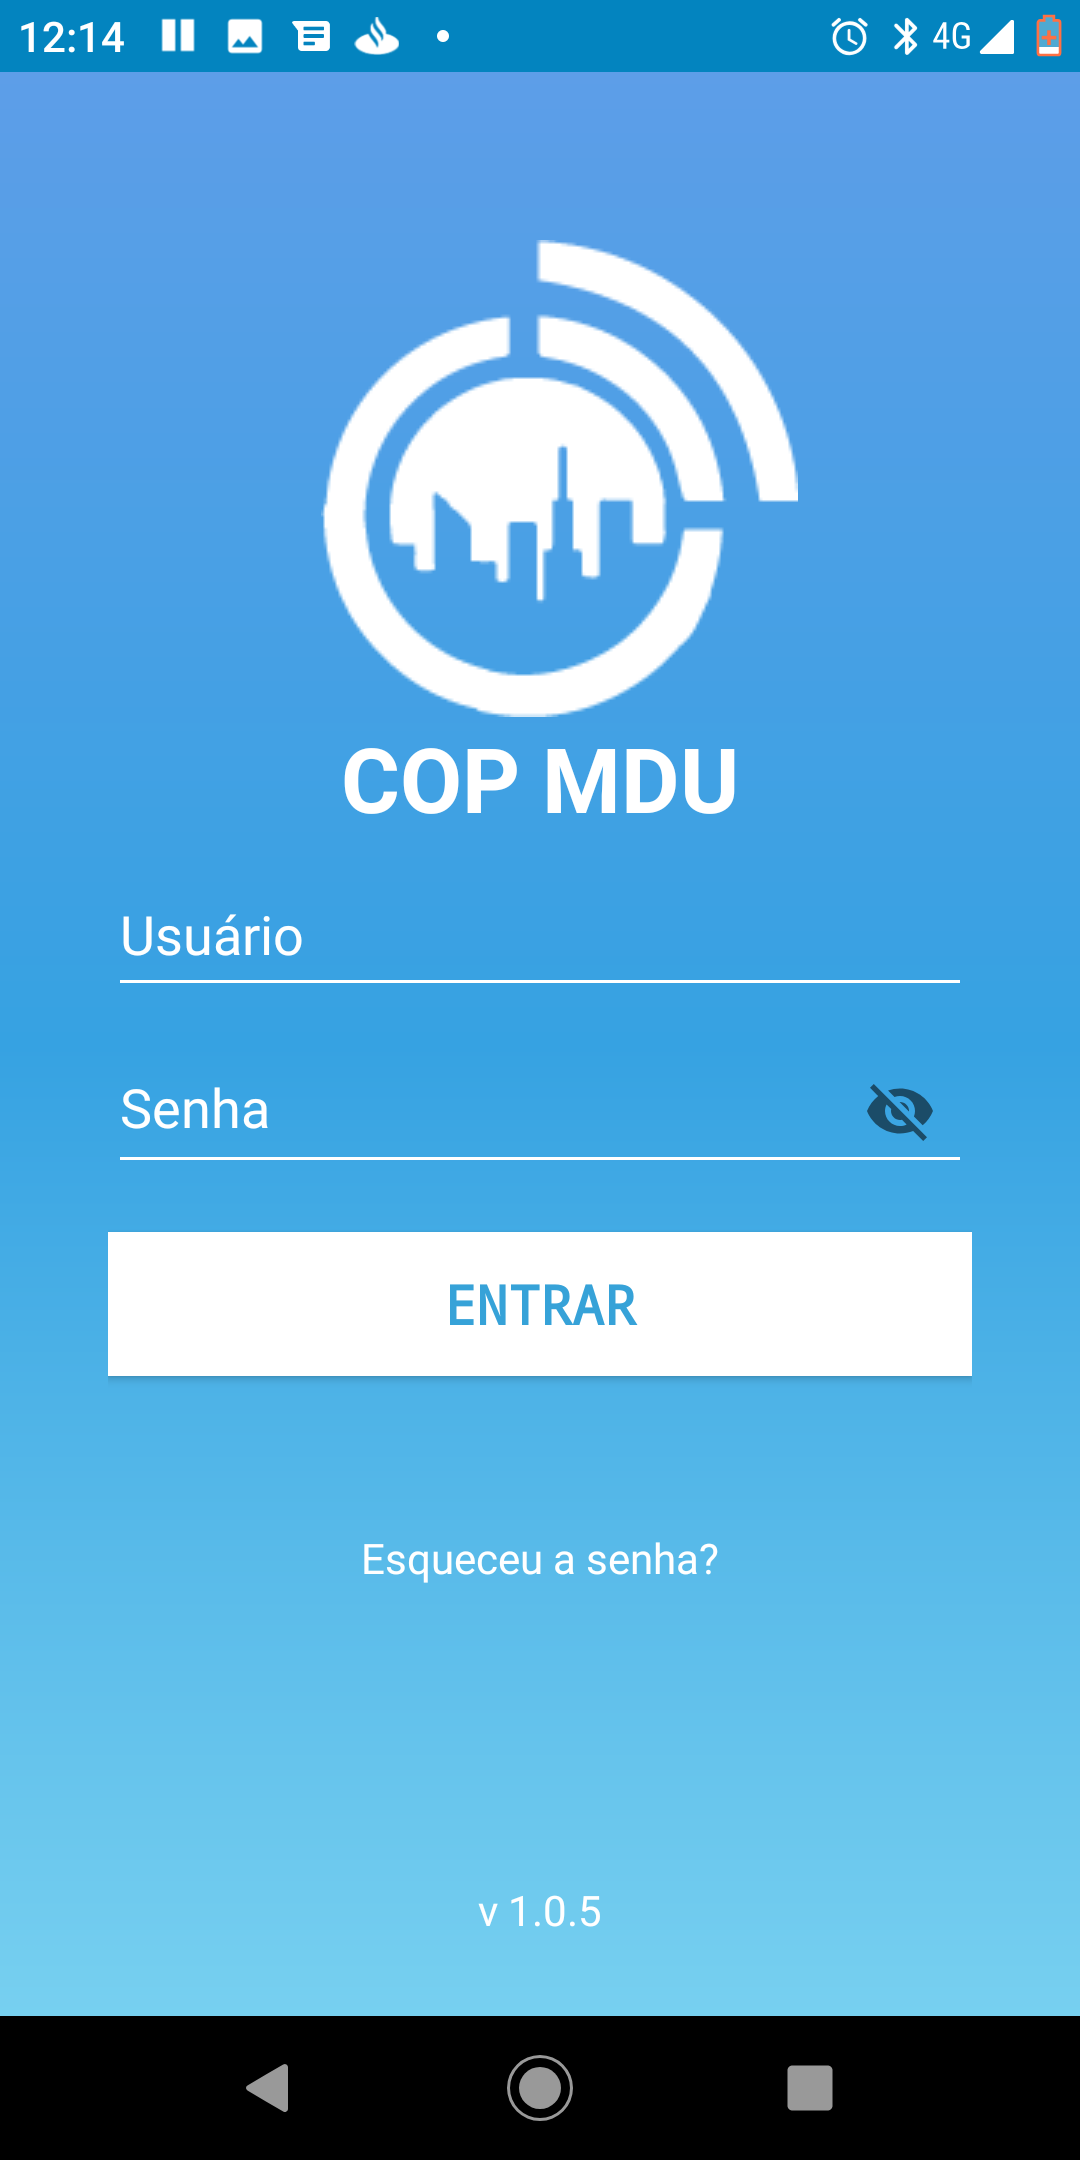

#### Esqueci A Senha
Preenche o usuário, esse usuário tem então sua senha resetada e a nova senha é enviada para o e-mail cadastrado na tabela [**User**](#User) após recuperado direciona novamente para a tela de [login](#Login).
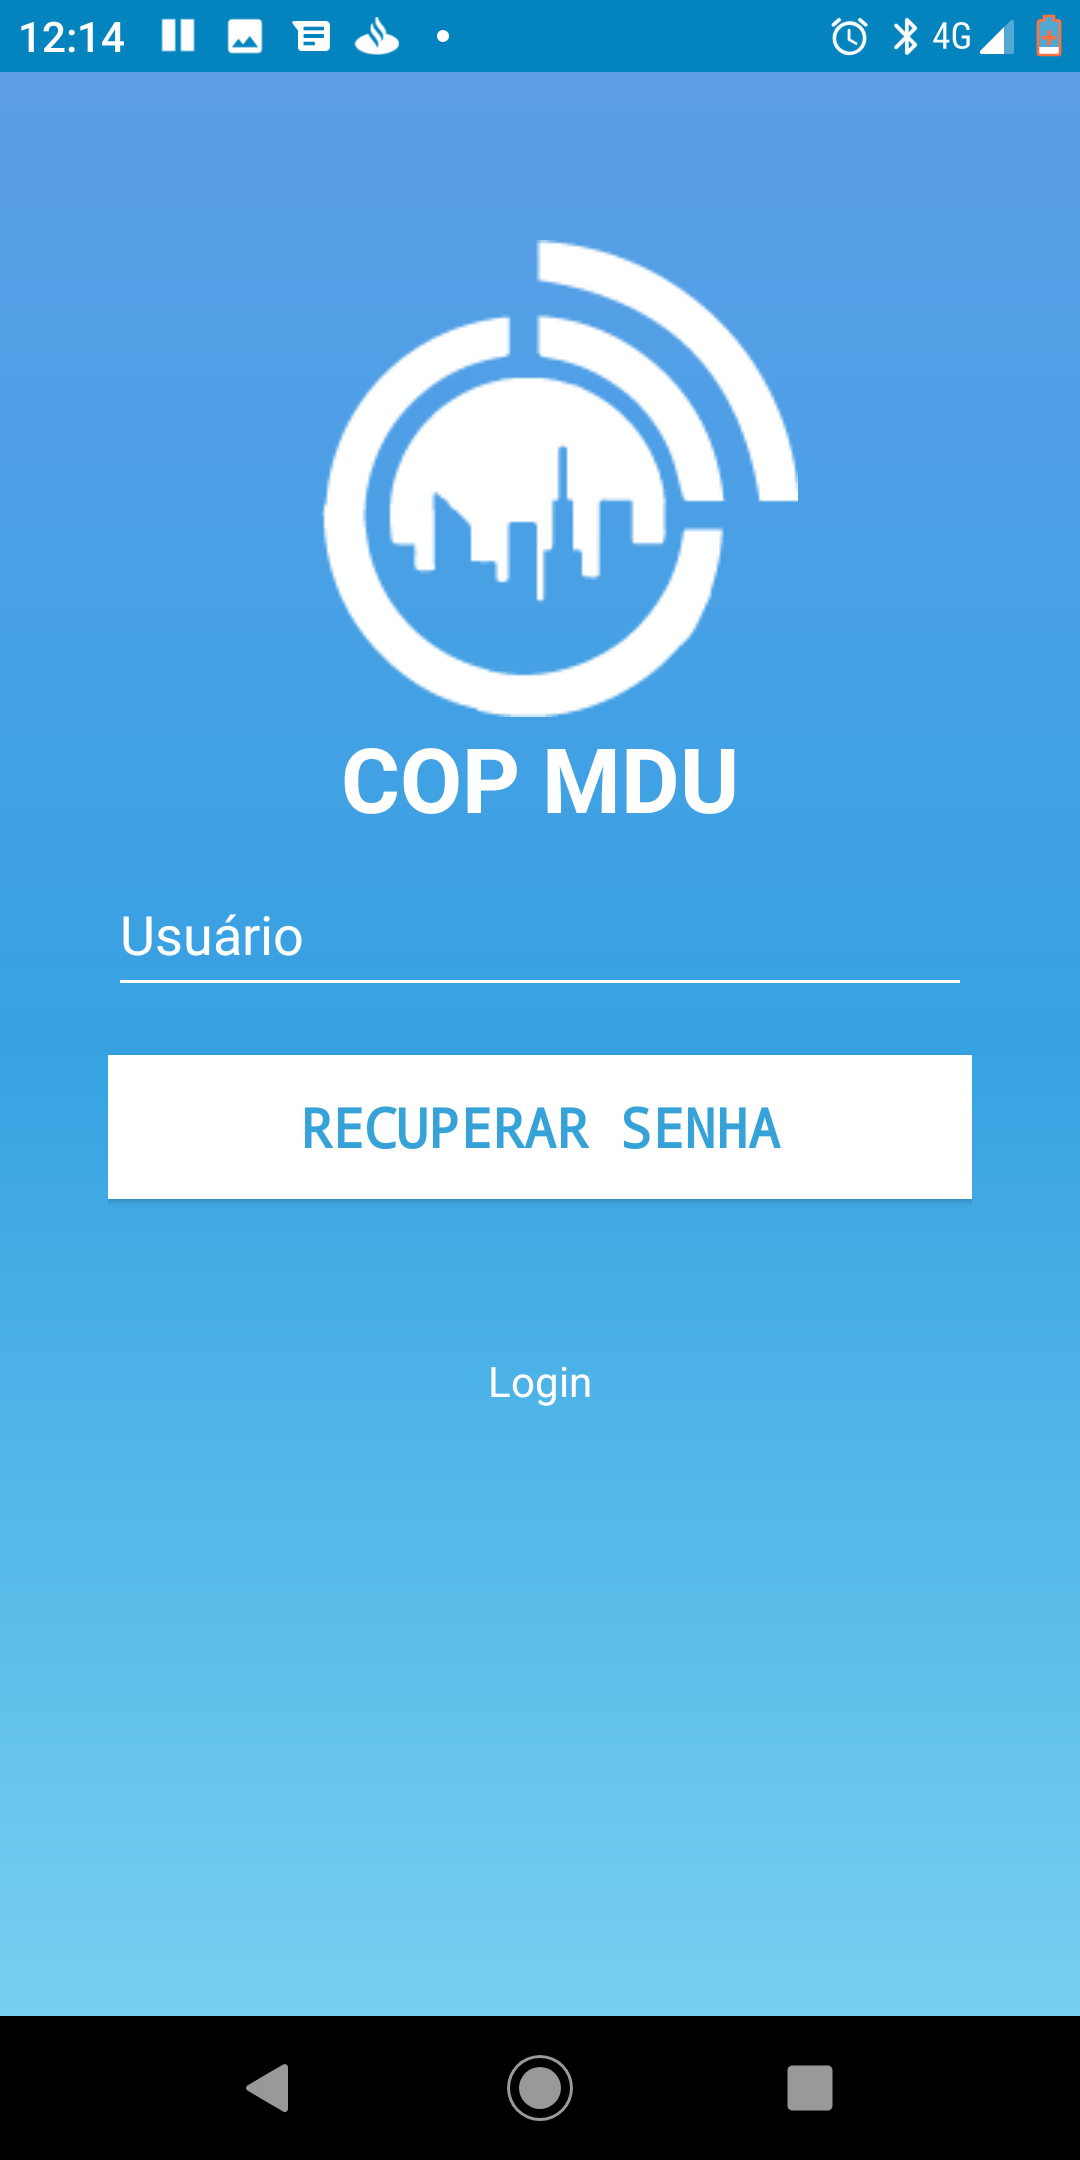

#### Listagem de Tickets
Traz a listagem da [consulta de outages](#Consulta-de-Outages) do técnico logado, caso esteja logado com o usuário do *serena* irá trazer todos os tickets.
Consegue acessar os [detalhes do ticket](#Detalhe-do-Ticket) selecionado, também tem acesso ao menu onde pode deslogar e ser direcionado para a tela de [login](#Login) ou pode clicar na *lupa* no canto superior direito que levará ele a tela de [fechamento](#Fechamento).
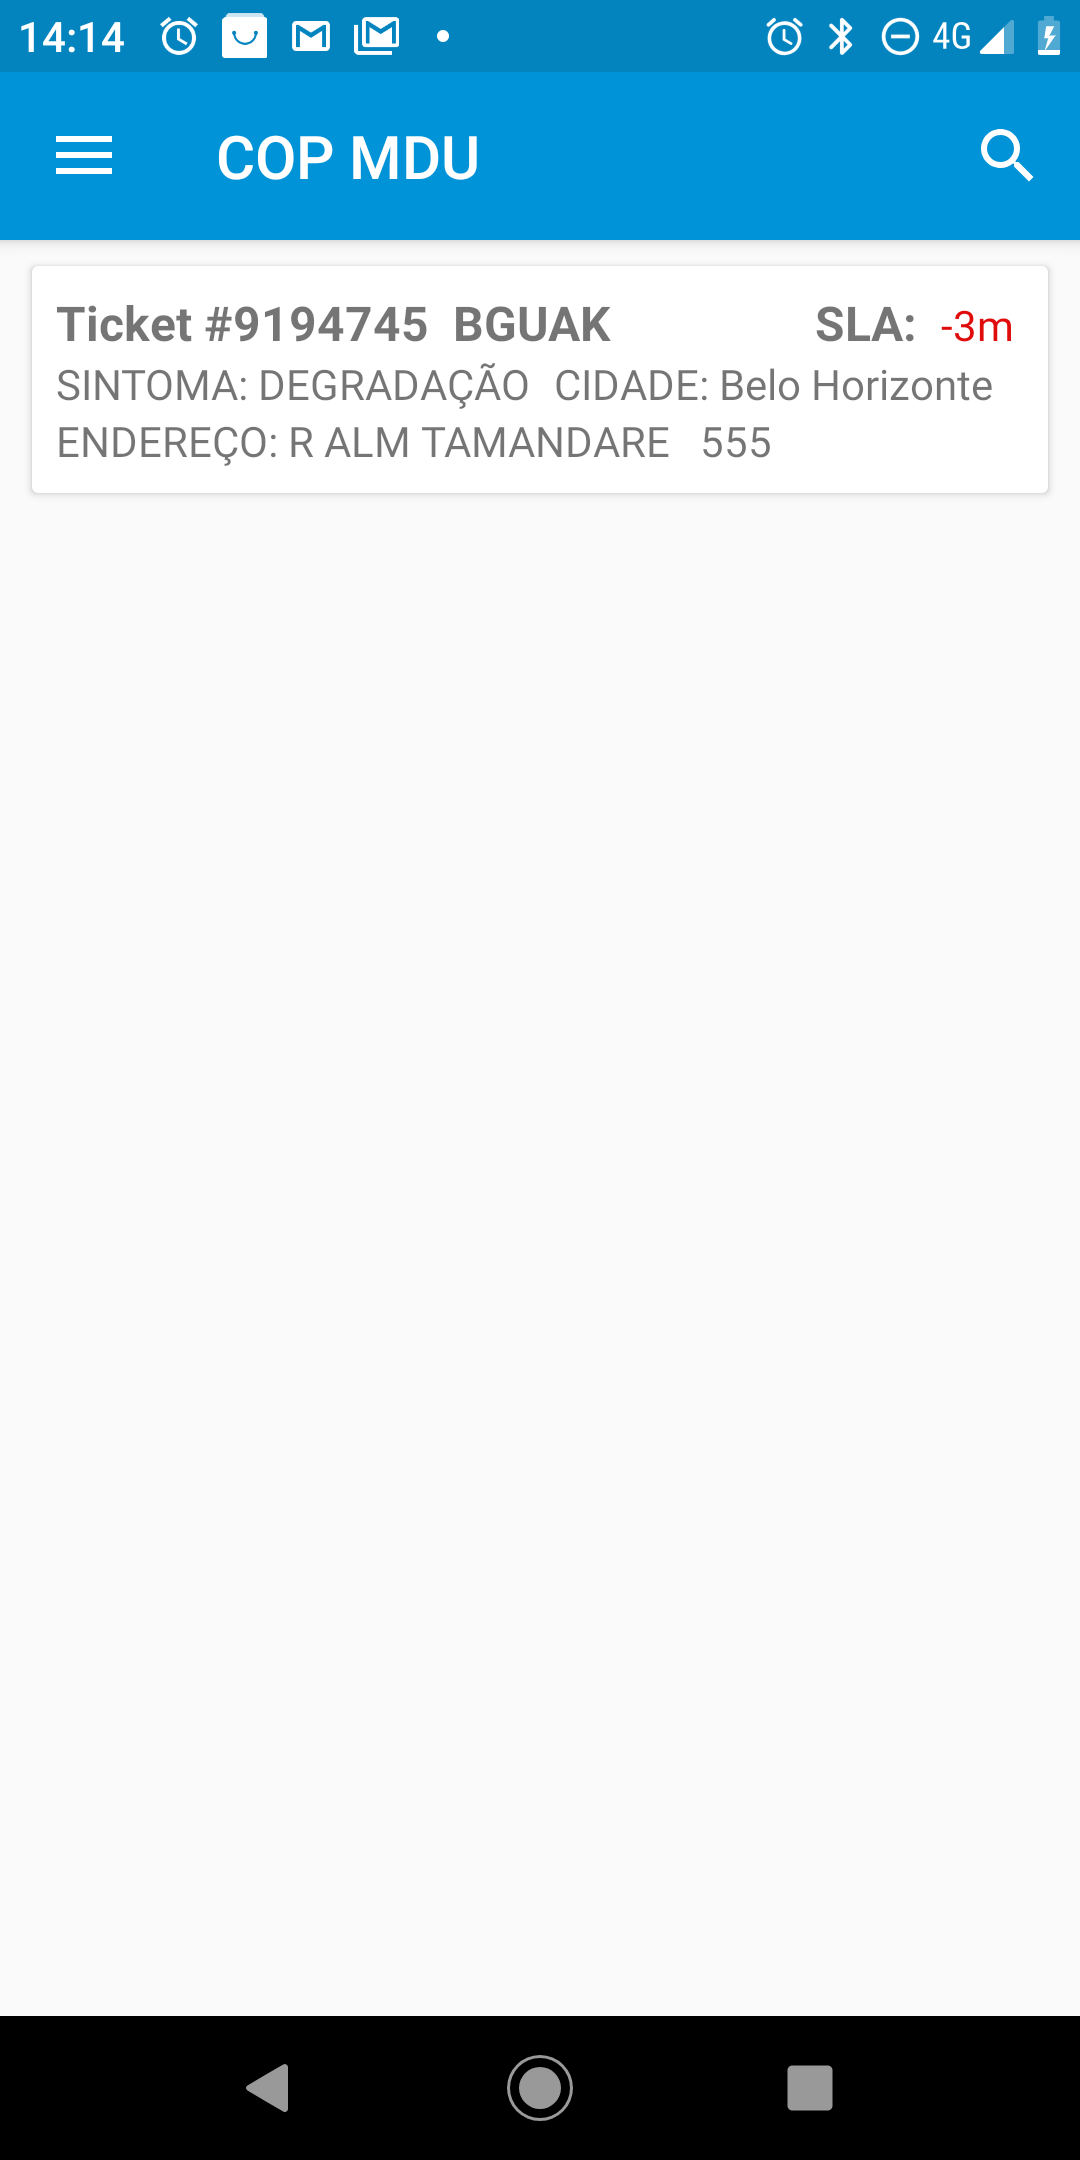

#### Detalhe do Ticket
Retorna dados adicionais da [consulta de outages](#Consulta-de-Outages) e permite alternar entre essa tela e a [medição de sinais](#Medição-de-Sinais).
Através dessa tela caso tenha terminado a validação de sinais e ele tenha passado ele irá habilitar o botão de *Fechar Ticket* que leva para a tela de [fechamento](#Fechamento).
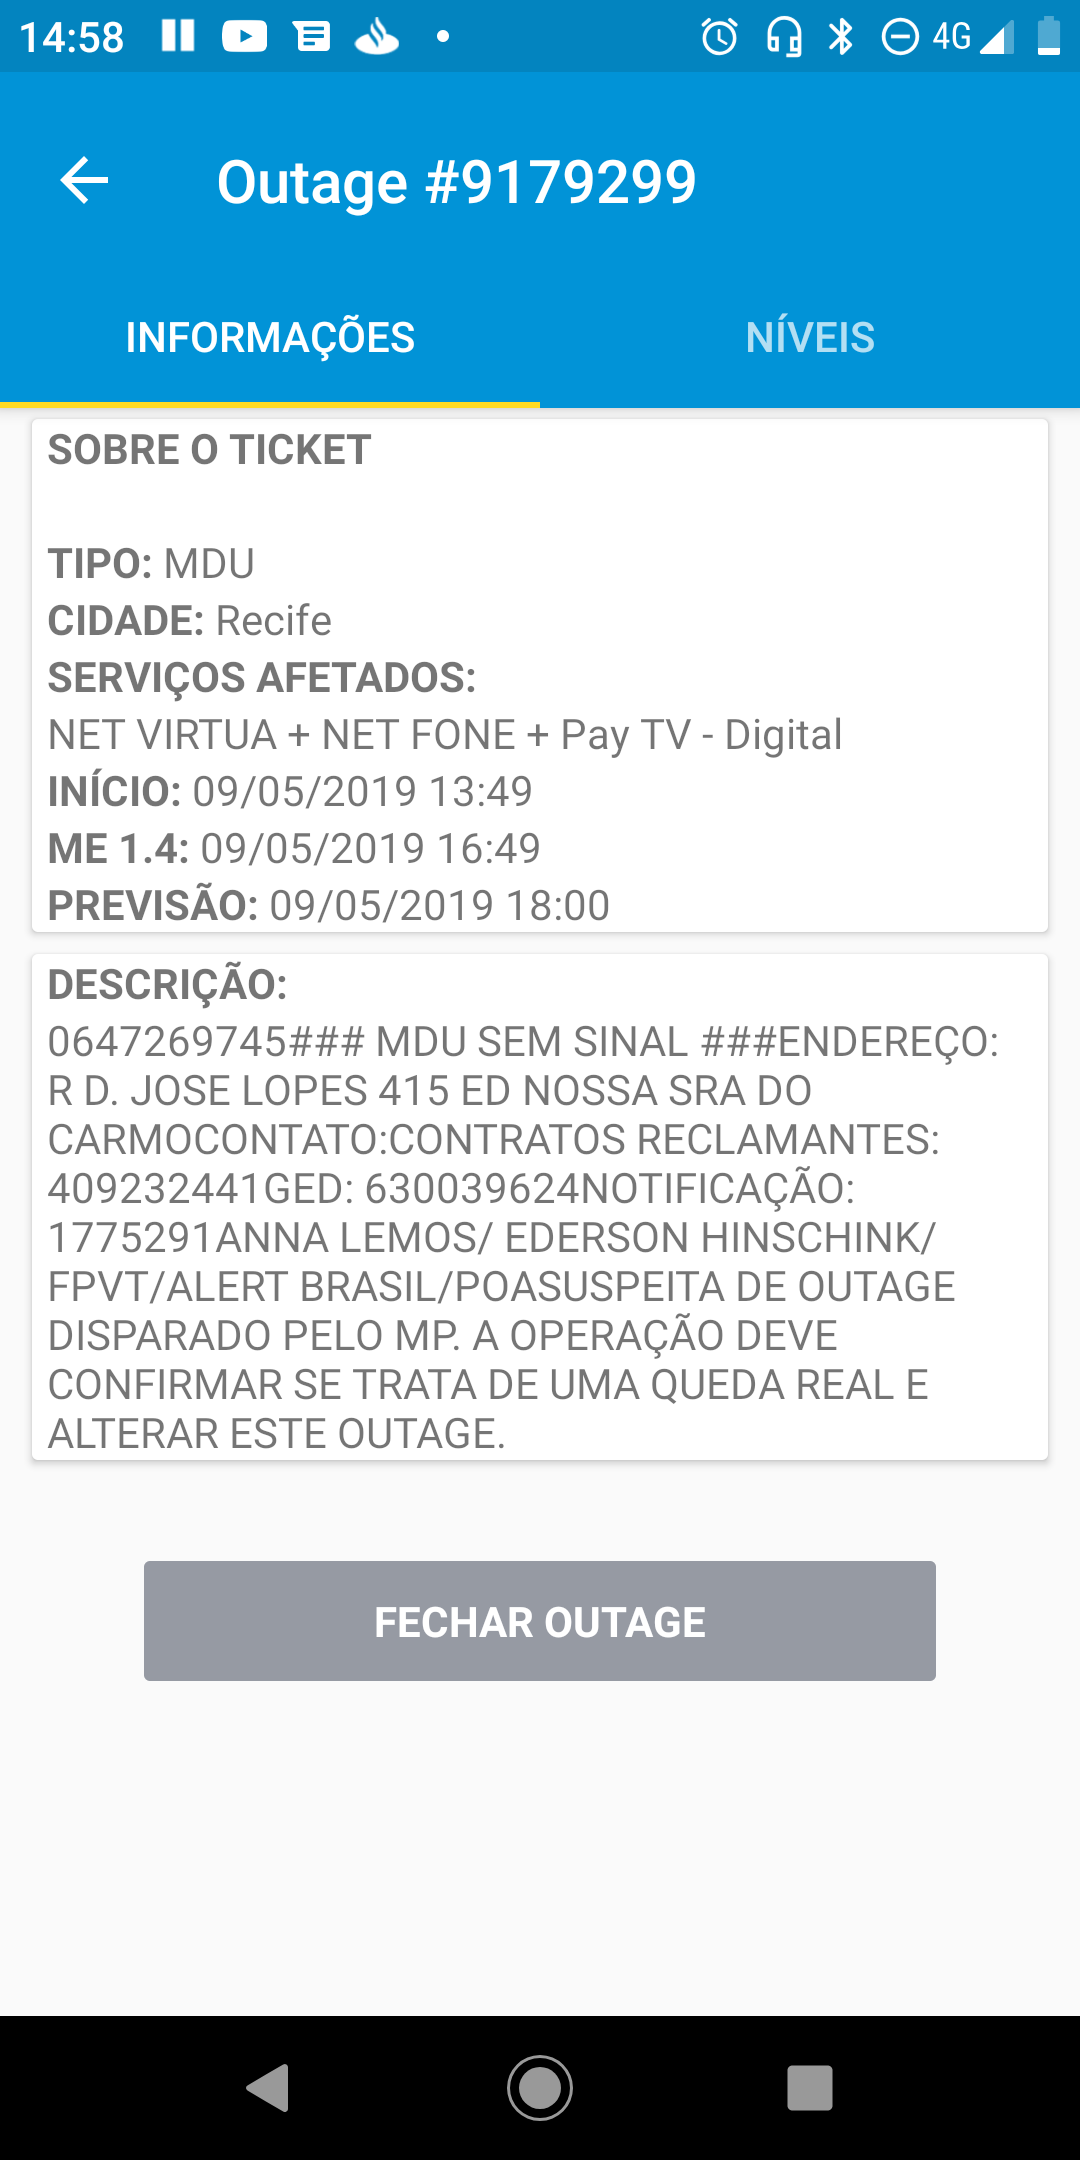

#### Medição de Sinais
Começa a medição assim que é aberta roda o processo de [consulta de níveis](#Consulta-de-niveis-de-sinais) caso consiga fazer a medição com sucesso mostra na tela a listagem, e o botão fica desabilitado de fazer novas consultas até dar o tempo de expiração de sinal onde poderá realizar uma nova consulta, em caso de falha na busca o botão fica habilitado imediatamente.
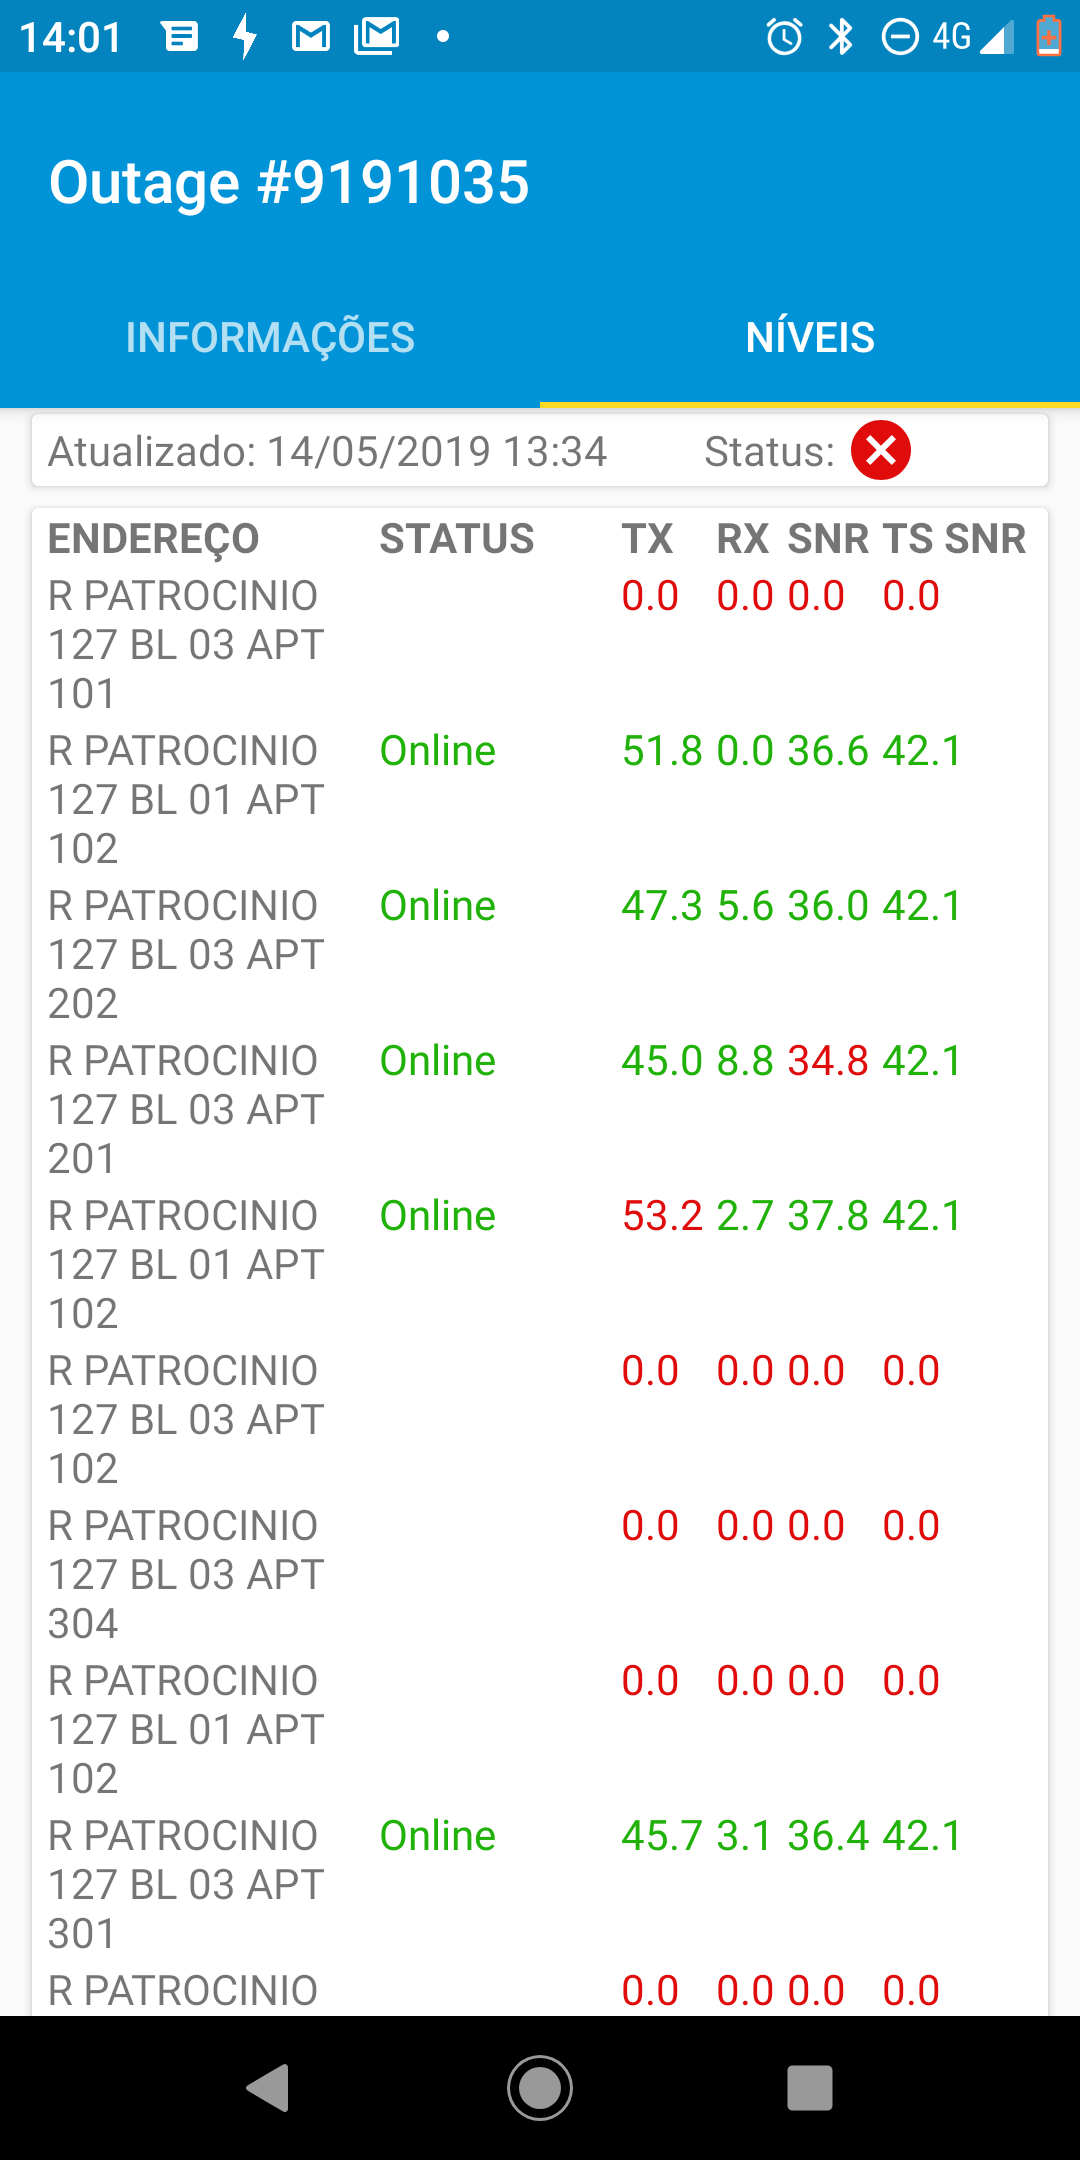

#### Fechamento
Preenche os dados de ticket motivo e observação, caso tenha vindo da tela de [listagem de tickets](#Listagem-de-Tickets) precisa preencher o número do ticket.  
Realiza o processo de [fechamento de ticket](#Fechamento-de-Outage) e redireciona para a tela de [resultado](#Resultado-Fechamento).
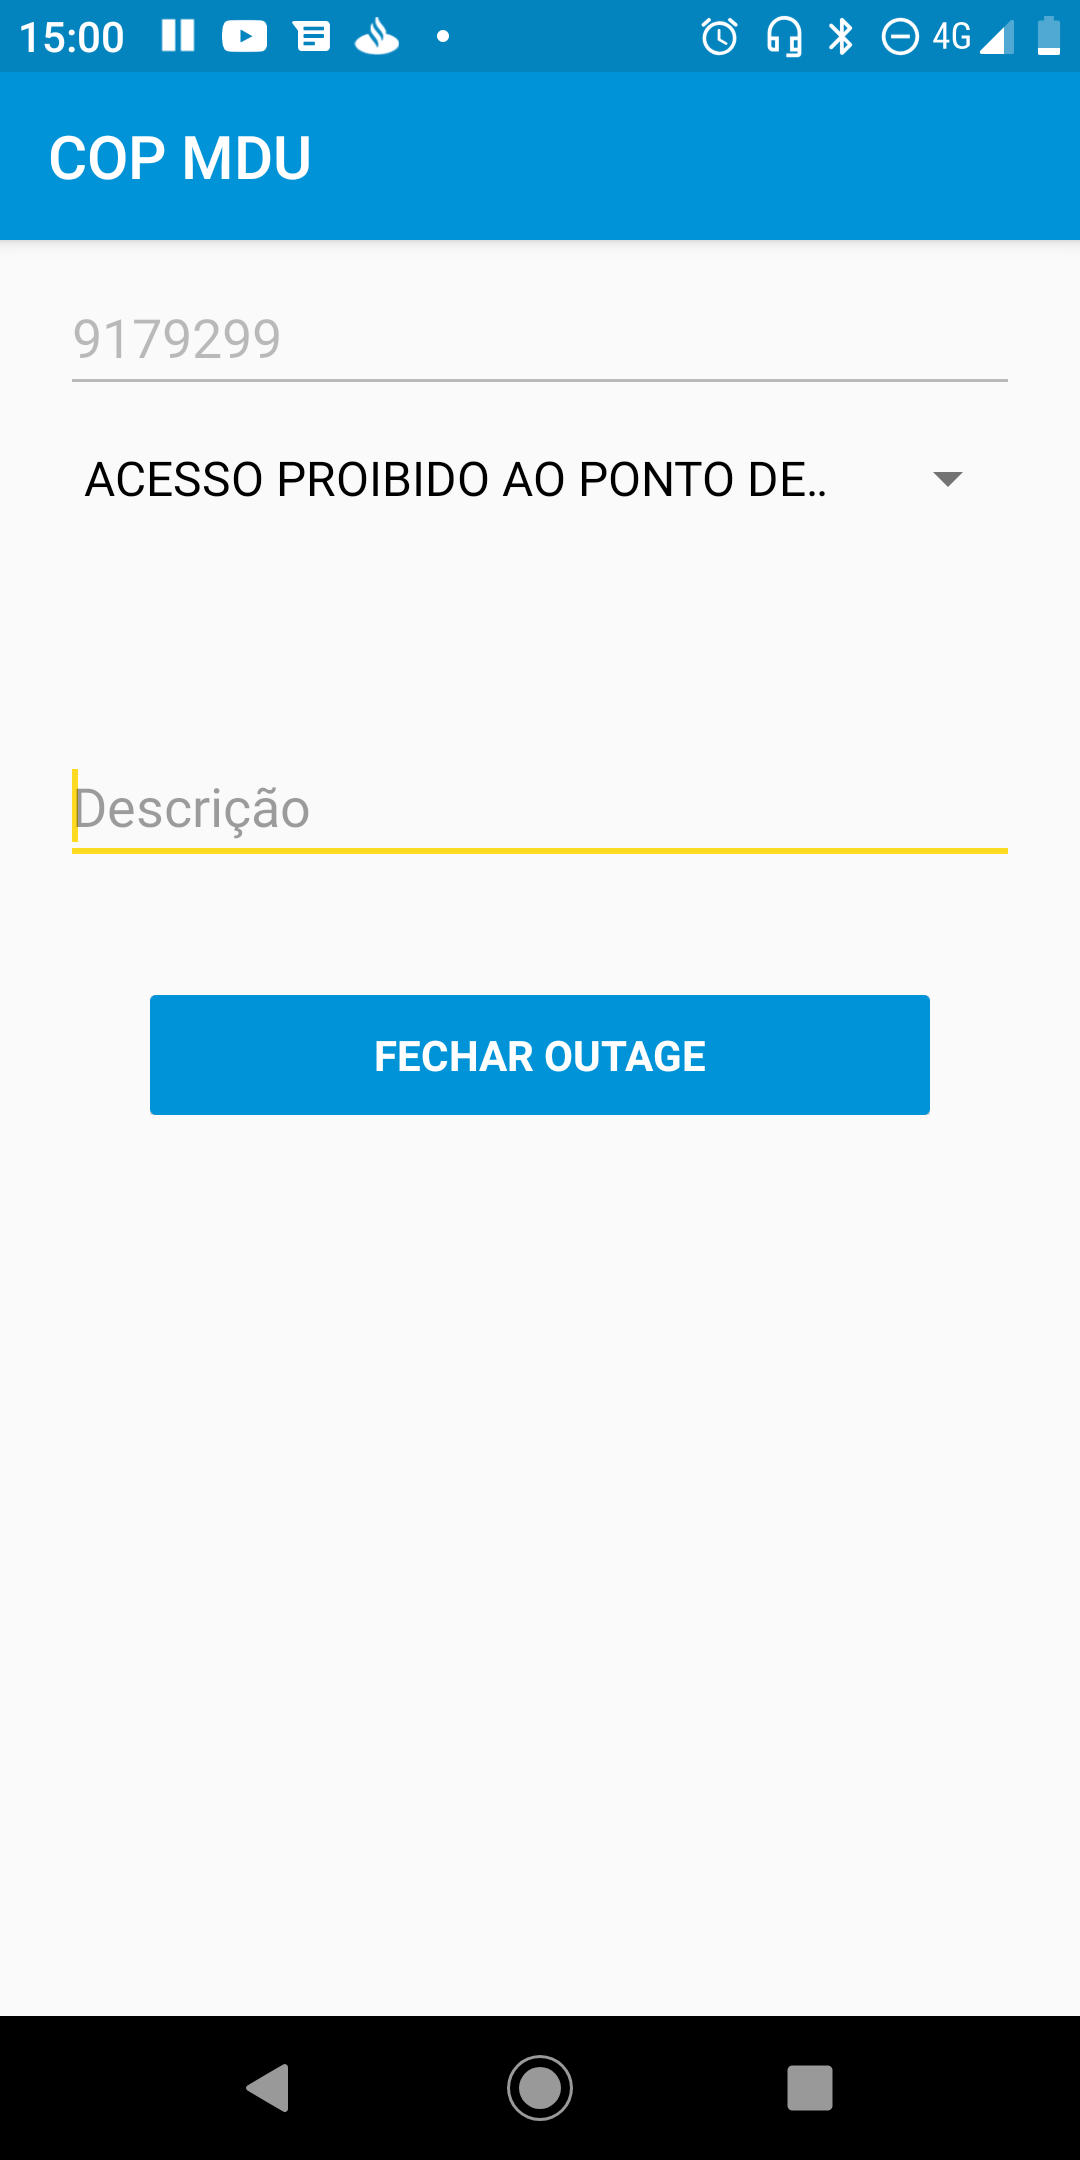

#### Resultado Fechamento
Tela com o resultado do [fechamento de ticket](#Fechamento-de-Outage). Dela poderá voltar para a tela de [listagem](#Listagem-de-Tickets).

## Estrutura
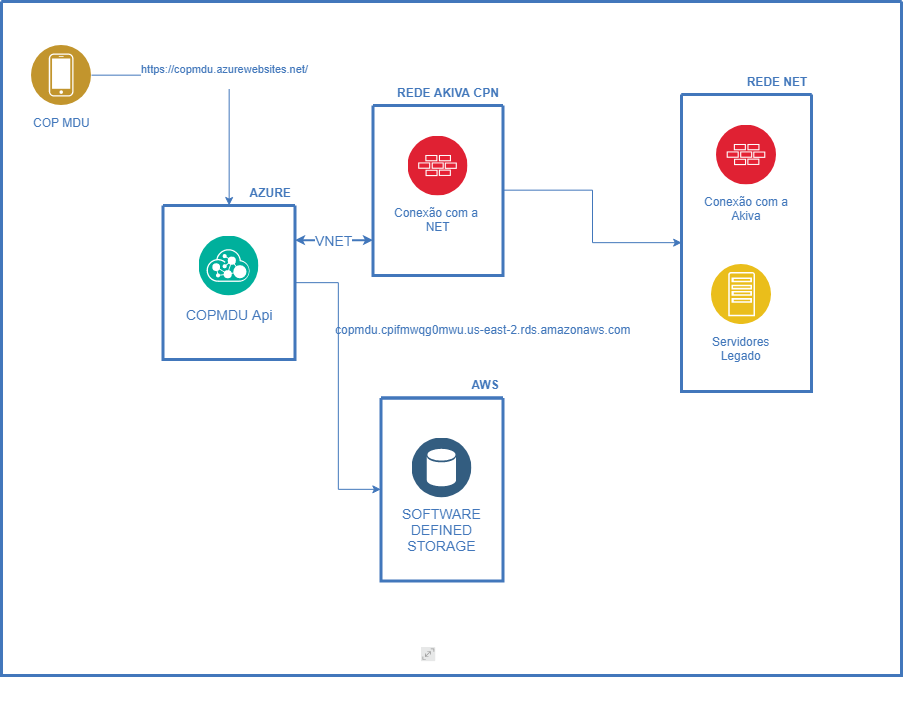